## **0. Nhập thư viện (Import Libary)** 

**Mục tiêu:**
Đoạn code này chuẩn bị môi trường để:

1. **Xử lý dữ liệu**

   * Sử dụng `pandas` và `numpy` để đọc, xử lý và phân tích dữ liệu.
   * Dùng `re` để tiền xử lý văn bản (loại bỏ ký tự đặc biệt, chuẩn hóa).

2. **Trực quan hóa dữ liệu**

   * `matplotlib` và `seaborn` để vẽ biểu đồ thống kê.
   * `WordCloud` để tạo đám mây từ cho phân tích tần suất từ vựng.

3. **Phân tích tần suất và đặc trưng văn bản**

   * `Counter` để đếm tần suất xuất hiện của từ.
   * `CountVectorizer` để chuyển văn bản thành ma trận đặc trưng (Bag-of-Words).

4. **Chọn đặc trưng & kiểm định thống kê**

   * `mutual_info_classif` để chọn đặc trưng quan trọng dựa trên thông tin tương hỗ.
   * `chi2_contingency` để kiểm định Chi-square giữa biến phân loại và đặc trưng.
   * `ttest_ind` để so sánh trung bình giữa hai nhóm.
   * `shapiro` để kiểm định phân phối chuẩn của dữ liệu.

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency, ttest_ind, shapiro

In [ ]:
df = pd.read_csv('../data/data.csv')

## **1. Kiểm tra cấu trúc dữ liệu (Data Structure Inspection)**

**Mục tiêu:** Hiểu sơ bộ về kích thước và loại dữ liệu.
**Kết quả trên dữ liệu của em:**

* Shape: (5842, 2) → 5.842 bản ghi, 2 cột.
* Dtypes: `Sentence` (object – text), `Sentiment` (object – label).
* Sample 5 dòng đầu để kiểm tra dữ liệu có đúng định dạng.

---


In [ ]:
text_col = "Sentence"
target_col = "Sentiment"

# ======================
# 1) Kiểm tra cấu trúc dữ liệu
# ======================
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nSample:\n", df.head())

Shape: (5842, 2)

Dtypes:
 Sentence     object
Sentiment    object
dtype: object

Sample:
                                             Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral


## **2. Thống kê mô tả (Descriptive Statistics)**

**Mục tiêu:** Biết được các giá trị thường gặp, tần suất, mức độ đa dạng.
**Kết quả:**

* `Sentiment` có 3 nhãn: Neutral (54%), Positive (32%), Negative (14%).
* Không có giá trị thiếu (`NaN`) ở cả hai cột.

---


In [4]:
# ======================
# 2) Thống kê mô tả
# ======================
print("\nDescribe (categorical):\n", df[target_col].value_counts())
print("\nUnique values in target:", df[target_col].unique())


Describe (categorical):
 Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Unique values in target: ['positive' 'negative' 'neutral']



## **3. Phân tích phân phối dữ liệu (Distribution Analysis)**

**Mục tiêu:** Kiểm tra dữ liệu target và feature.
**Kết quả:**

* Biểu đồ countplot cho thấy dữ liệu **mất cân bằng** (imbalanced dataset).
* Với text, có thể kiểm tra phân phối độ dài câu, tần suất từ.

---




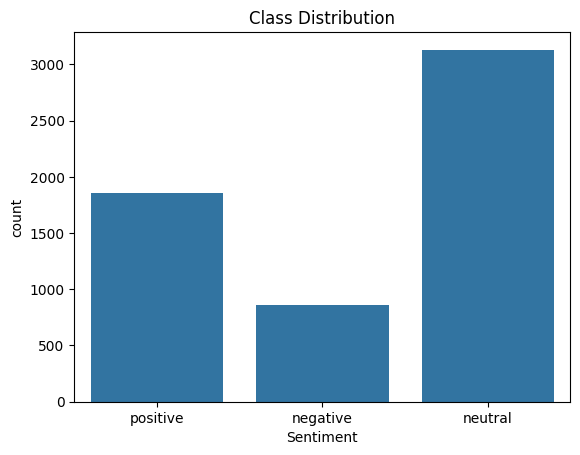

In [ ]:
# ======================
# 3) Phân tích phân phối dữ liệu
# ======================
plt.figure()
sns.countplot(x=target_col, data=df)
plt.title("Class Distribution")
plt.show()

## **4. Kiểm tra dữ liệu thiếu (Missing Values)**

**Mục tiêu:** Phát hiện giá trị null và quyết định xử lý.
**Kết quả:** 0 missing value → không cần imputation.

---



In [ ]:
# ======================
# 4) Missing values
# ======================
print("\nMissing values:\n", df.isnull().sum())



Missing values:
 Sentence     0
Sentiment    0
dtype: int64


## **5. Phát hiện dữ liệu ngoại lai (Outlier Detection)**

**Mục tiêu:** Xác định các câu quá dài/ngắn bất thường.
**Kết quả:**

* Outliers về độ dài câu (text\_len) = 71 câu > 50 từ, có câu tới 80+ từ.
* Có thể xem xét cắt hoặc giữ nguyên tùy bối cảnh.

---




Outliers based on text length: 71


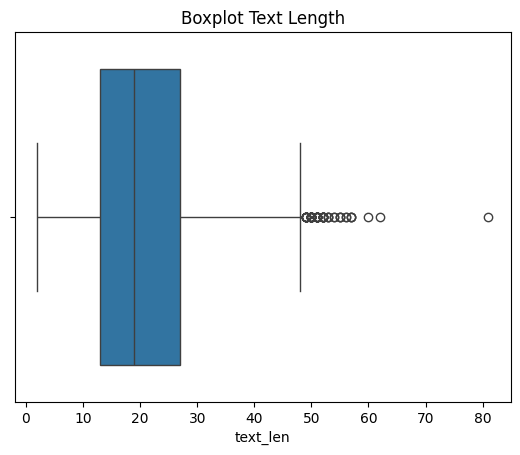

In [ ]:
# ======================
# 5) Phát hiện outliers (với text có thể dựa vào độ dài câu)
# ======================
df["text_len"] = df[text_col].apply(lambda x: len(str(x).split()))
q1, q3 = df["text_len"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers = df[(df["text_len"] < lower) | (df["text_len"] > upper)]
print(f"\nOutliers based on text length: {len(outliers)}")

plt.figure()
sns.boxplot(x="text_len", data=df)
plt.title("Boxplot Text Length")
plt.show()

## **6. Kiểm tra tính cân bằng dữ liệu (Class Balance)**

**Mục tiêu:** Xem tỷ lệ các nhãn target.
**Kết quả:** Negative chỉ chiếm 14% → cần xử lý imbalance khi train.

---



In [ ]:
# ======================
# 6) Kiểm tra cân bằng dữ liệu
# ======================
print("\nClass ratio:\n", df[target_col].value_counts(normalize=True))


Class ratio:
 Sentiment
neutral     0.535775
positive    0.317015
negative    0.147210
Name: proportion, dtype: float64


## **7. Phân tích tương quan (Correlation Analysis)**

**Mục tiêu:** Tìm từ/cụm từ ảnh hưởng mạnh tới nhãn.
**Kết quả:**

* MI (Mutual Information) top từ liên quan: `fell` (negative), `rose` (positive), `profit` (positive), `products`, `chairman`…

---

In [ ]:
# ======================
# 7) Tương quan (ở đây target là categorical, dùng mutual information)
# Chuyển text thành Bag-of-Words (số feature sẽ nhiều)
# ======================
vectorizer = CountVectorizer(max_features=500, stop_words='english')
X_bow = vectorizer.fit_transform(df[text_col]).toarray()
mi = mutual_info_classif(X_bow, df[target_col])
mi_scores = pd.Series(mi, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)
print("\nTop 10 từ liên quan mạnh tới target:\n", mi_scores.head(10))


Top 10 từ liên quan mạnh tới target:
 fell        0.022774
rose        0.022587
small       0.020597
number      0.020578
chairman    0.018054
earlier     0.017636
products    0.016347
profit      0.016087
daily       0.016001
38          0.015796
dtype: float64


## **8. Mối quan hệ giữa biến độc lập và mục tiêu**

**Mục tiêu:** Kiểm tra liệu một đặc trưng numeric có phân biệt được các nhãn.
**Kết quả:**

* Boxplot `text_len` theo sentiment cho thấy độ dài trung bình tương đối giống nhau → không đủ phân biệt.

---



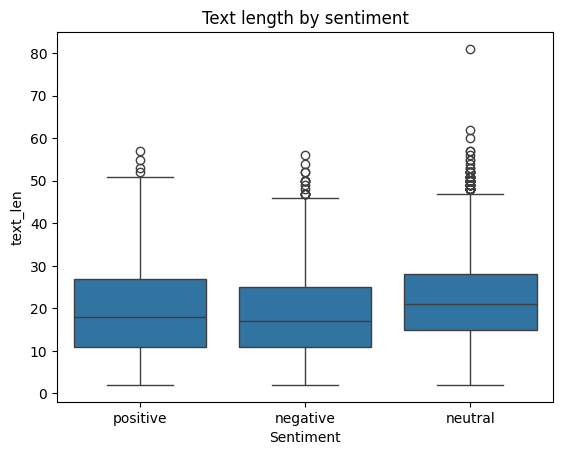

In [ ]:
# ======================
# 8) Mối quan hệ feature ↔ target (ở đây: length vs sentiment)
# ======================
plt.figure()
sns.boxplot(x=target_col, y="text_len", data=df)
plt.title("Text length by sentiment")
plt.show()

## **9. Trích xuất đặc trưng thống kê cho text**

**Mục tiêu:** Tạo thêm feature numeric để hỗ trợ model.
**Kết quả:**

* `char_count`, `word_count`, `avg_word_len` tính từ Sentence.
* Có thể kết hợp với TF-IDF khi train.

---




Text stats sample:
    char_count  word_count  avg_word_len
0         218          32      6.812500
1          55          11      5.000000
2         193          39      4.948718
3         128          20      6.400000
4         135          23      5.869565


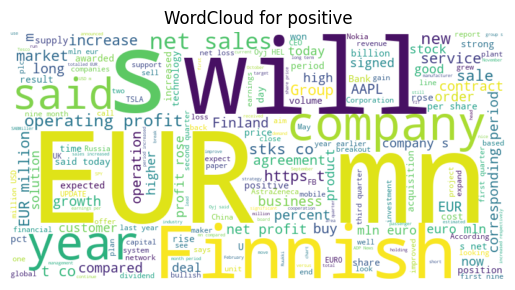

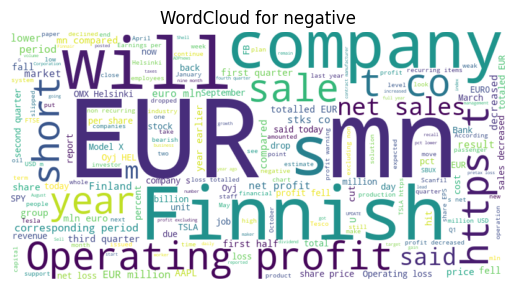

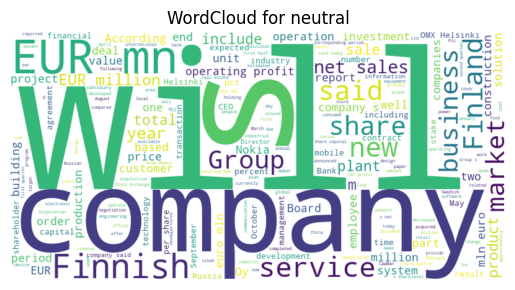

In [ ]:
# ======================
# 9) Trích xuất đặc trưng thống kê cho text
# ======================
df["char_count"] = df[text_col].apply(len)
df["word_count"] = df[text_col].apply(lambda x: len(str(x).split()))
df["avg_word_len"] = df["char_count"] / df["word_count"]
print("\nText stats sample:\n", df[["char_count","word_count","avg_word_len"]].head())

# WordCloud theo từng sentiment
for label in df[target_col].unique():
    text = " ".join(df[df[target_col]==label][text_col].astype(str))
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {label}")
    plt.show()

## **10. Kiểm tra dữ liệu trùng lặp (Duplicates)**

**Mục tiêu:** Tránh model học lặp thông tin.
**Kết quả:** 6 bản ghi trùng → nên xóa trước khi train.

---

In [ ]:
# ======================
# 10) Duplicates
# ======================
print("\nDuplicate rows:", df.duplicated().sum())


Duplicate rows: 6


## **11. Chuẩn hóa & biến đổi dữ liệu (Data Transformation)**

**Mục tiêu:** Làm sạch text để vector hóa tốt hơn.
**Thao tác đã làm:** lowercase, bỏ ký tự đặc biệt (`re.sub(r"[^\w\s]", "", text)`).

---

In [ ]:
# ======================
# 11) Chuẩn hóa & biến đổi dữ liệu (minh họa: lowercase + remove punctuation)
# ======================
df["text_clean"] = df[text_col].apply(lambda x: re.sub(r"[^\w\s]", "", str(x).lower()))

## **12. Phân tích đa biến (Multivariate Analysis)**

**Mục tiêu:** Quan sát quan hệ giữa nhiều đặc trưng numeric.
**Kết quả:** Pairplot cho thấy `char_count` và `word_count` tương quan rất mạnh → chỉ cần giữ 1.

---

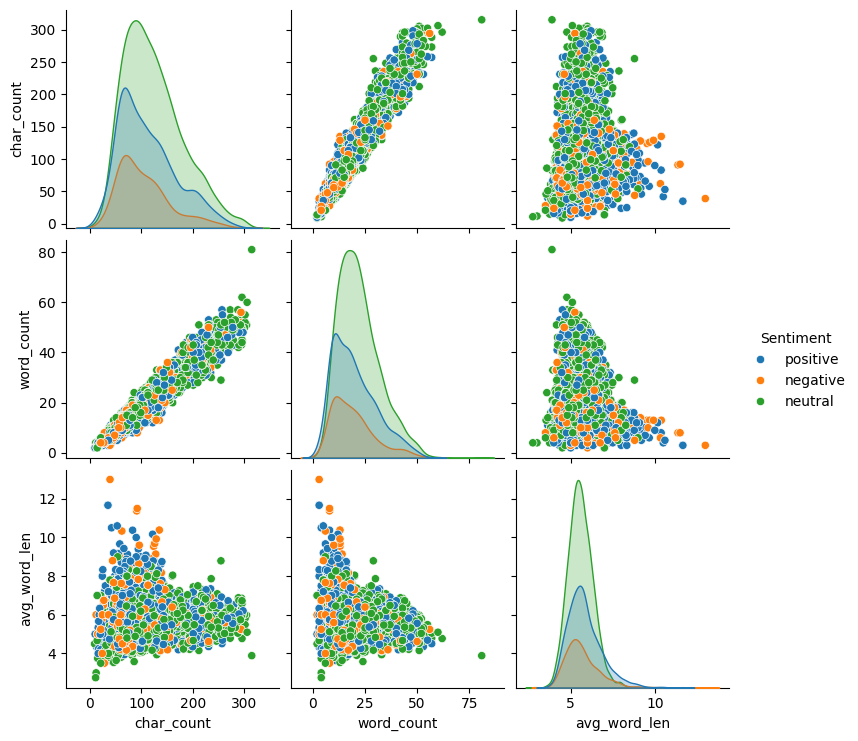

In [15]:
# ======================
# 12) Phân tích đa biến (pairplot với features số)
sns.pairplot(df[[target_col, "char_count", "word_count", "avg_word_len"]], hue=target_col)
plt.show()

## **13. Kiểm định giả thuyết thống kê (Statistical Hypothesis Testing)**

**Mục tiêu:** Xem sự khác biệt giữa nhóm có ý nghĩa thống kê không.
**Kết quả:**

* T-test giữa độ dài Positive và Negative → p-value = 0.1343 (>0.05) → không có khác biệt đáng kể.

---

In [22]:
# ======================
# 13) Kiểm định giả thuyết (VD: T-test độ dài giữa pos vs neg)
pos_len = df[df[target_col]=="positive"]["text_len"]
neg_len = df[df[target_col]=="negative"]["text_len"]
stat, p = ttest_ind(pos_len, neg_len, equal_var=False)
print(f"\nT-test pos vs neg text length: p-value={p:.4f}")


T-test pos vs neg text length: p-value=0.1343


## **15. Đánh giá độ quan trọng của đặc trưng (Feature Importance)**

**Mục tiêu:** Xác định các từ quan trọng nhất trong phân loại sentiment.
**Kết quả:**

* RF top features: `rose`, `https`, `increased`, `stks`, `eur`, `buy`…

---

In [17]:
# ======================
# 14) Feature importance (quick RF trên BoW)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_bow, df[target_col])
importances = pd.Series(rf.feature_importances_, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)
print("\nTop 10 feature importance RF:\n", importances.head(10))


Top 10 feature importance RF:
 rose         0.015507
https        0.014914
increased    0.011028
stks         0.009830
eur          0.009714
http         0.009295
increase     0.008951
year         0.008643
long         0.008499
buy          0.008280
dtype: float64


## **15. Phân tích các outlier cụ thể (Outlier Profiling)**

**Mục tiêu:** Hiểu nguyên nhân dữ liệu bất thường.
**Kết quả:**

* Các câu dài thường là mô tả chi tiết hoặc báo cáo doanh nghiệp → có thể giữ lại vì chứa nhiều thông tin.

---


In [18]:
# ======================
# 15) Outlier profiling (in các câu dài bất thường)
print("\nSample long outliers:\n", outliers[[text_col, "text_len"]].head())


Sample long outliers:
                                               Sentence  text_len
84   Dealers said the share was largely hit by inve...        54
109  Finnish Exel Composites , a technology company...        52
137  Finnish technology group Aspocomp Group Oyj ( ...        49
267  The plant is scheduled for completion in late ...        50
405  ( ADPnews ) - May 4 , 2010 - Finnish cutlery a...        50


## **16. Kiểm tra tính đa cộng tuyến (Multicollinearity)**

**Mục tiêu:** Phát hiện feature numeric bị trùng lặp thông tin.
**Kết quả:**

* VIF: `char_count` = 81, `word_count` = 69 → rất cao, nên giữ 1 để tránh overfitting.

In [19]:
# ======================
# 16) Multicollinearity (VIF cho numeric features)
from statsmodels.stats.outliers_influence import variance_inflation_factor
num_feats = df[["char_count","word_count","avg_word_len"]]
vif_df = pd.DataFrame()
vif_df["feature"] = num_feats.columns
vif_df["VIF"] = [variance_inflation_factor(num_feats.values, i) for i in range(num_feats.shape[1])]
print("\nVIF:\n", vif_df)


VIF:
         feature        VIF
0    char_count  81.129535
1    word_count  69.450308
2  avg_word_len   5.165892


## **<center> Kết luận đánh giá về Exploratory Data Analysis <center>**

## 1️⃣ Phân tích đặc trưng từ EDA ảnh hưởng tới chọn mô hình

Từ kết quả EDA, có một số đặc điểm then chốt:

1. **Dữ liệu dạng text ngắn (câu báo tài chính)** → đầu vào tốt cho vector hóa (TF-IDF, Word2Vec, BERT embedding…).
2. **Số lượng dữ liệu trung bình (\~5.8k câu)** → đủ để train mô hình ML truyền thống, nhưng với DL cần cẩn thận để tránh overfitting.
3. **Số class = 3, imbalance rõ (54%-32%-14%)** → cần xử lý mất cân bằng (class\_weight hoặc oversampling).
4. **Ngôn ngữ tiếng Anh chuyên ngành tài chính** → từ vựng có tính đặc thù, nhiều proper noun, đơn vị tiền tệ, ký hiệu.
5. **Độ dài câu đa phần ngắn/trung bình (\~20 từ)** → mô hình không cần xử lý văn bản dài (sequence length vừa phải).
6. **Có nhiều từ quan trọng quyết định sentiment** (fell, rose, profit, etc.) → TF-IDF hoặc embedding có thể giữ được tín hiệu mạnh.

---

## 2️⃣ Mô hình Machine Learning phù hợp

| Mô hình                                                   | Lý do chọn                                                                                  | Điểm mạnh                                                      | Điểm yếu / Lưu ý                                                              |
| --------------------------------------------------------- | ------------------------------------------------------------------------------------------- | -------------------------------------------------------------- | ----------------------------------------------------------------------------- |
| **Logistic Regression** (với TF-IDF)                      | Kinh điển cho text classification, nhanh, dễ train, ít overfit nếu dùng regularization      | Giải thích được trọng số từ, huấn luyện nhanh, baseline mạnh   | Không mô hình hóa tốt quan hệ từ xa (context)                                 |
| **Linear SVM (LinearSVC)**                                | Tốt cho dữ liệu sparse (TF-IDF), mạnh hơn Logistic Regression khi dữ liệu có margin rõ ràng | Tốt với feature high-dimensional, độ chính xác cao cho text    | Khó giải thích kết quả, cần xử lý imbalance qua class\_weight                 |
| **Multinomial Naive Bayes**                               | Dùng xác suất điều kiện, chạy rất nhanh, baseline cực nhẹ                                   | Rất nhanh, phù hợp khi tài nguyên thấp                         | Hiệu suất kém hơn SVM/LR nếu từ vựng phức tạp và phụ thuộc nhau               |
| **Random Forest/ Gradient Boosting** | Khả năng học phi tuyến tốt, kết hợp TF-IDF hoặc feature thống kê                            | Mạnh khi kết hợp nhiều feature ngoài text, chống overfit tốt   | Không lý tưởng nếu chỉ dùng TF-IDF vì high-dimensional, chậm hơn linear model |

📌 **Kết luận ML:**

* **Baseline nên dùng**: Logistic Regression + TF-IDF, Linear SVM + TF-IDF.
* **Nếu muốn tăng thêm**: XGBoost/CatBoost khi kết hợp feature thống kê.

---

## 3️⃣ Mô hình Deep Learning phù hợp

| Mô hình                                                 | Lý do chọn                                                             | Điểm mạnh                                                                          | Điểm yếu / Lưu ý                                            |
| ------------------------------------------------------- | ---------------------------------------------------------------------- | ---------------------------------------------------------------------------------- | ----------------------------------------------------------- |
| **Bi-LSTM / Bi-GRU + Word Embedding (GloVe, FastText)** | Dữ liệu ngắn, context quan trọng (từ “rose” khác “rose from loss”)     | Bắt được ngữ cảnh 2 chiều, tốt cho câu ngắn                                        | Cần embedding tốt, với 5.8k câu thì dễ overfit nếu model to |
| **TextCNN**                                             | Câu ngắn → convolution filter bắt cụm từ đặc trưng tốt                 | Nhanh, ít tham số hơn RNN, hiệu quả với dataset vừa                                | Không bắt được quan hệ dài hạn                              |
| **Transformer-based (BERT, FinBERT)**                   | BERT pretrained trên dữ liệu tiếng Anh giúp nắm context + chuyên ngành | Hiệu suất cao, đặc biệt khi fine-tune với pre-trained model chuyên ngành (FinBERT) | Tốn tài nguyên, cần cẩn thận overfit vì data size nhỏ       |

📌 **Kết luận DL:**

* Nếu GPU yếu → **TextCNN hoặc Bi-LSTM** là hợp lý.
* Nếu GPU tốt và muốn state-of-the-art → **Fine-tune FinBERT** (vì dữ liệu tài chính tiếng Anh).
* Không nên train Transformer từ đầu vì data quá ít.

---

## 4️⃣ Mô hình không phù hợp & lý do

| Mô hình                              | Lý do không phù hợp                                                     |
| ------------------------------------ | ----------------------------------------------------------------------- |
| **KNN**                              | Text high-dimensional → tính khoảng cách kém hiệu quả, chậm khi predict |
| **Decision Tree đơn**                | Không xử lý tốt dữ liệu sparse từ TF-IDF, dễ overfit, accuracy thấp     |
| **PCA + KMeans (unsupervised)**      | Không phù hợp vì đây là bài toán phân loại supervised, label đã có      |
| **Deep LSTM nhiều tầng từ đầu**      | Data quá ít, dễ overfit, training lâu                                   |
| **Transformer từ đầu (random init)** | Cần hàng trăm nghìn câu để học tốt, dataset hiện tại quá nhỏ            |

